In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
print(mi.variants())
mi.set_variant('cuda_ad_rgb')

import mitransient as mitr

print('Using mitsuba version:', mi.__version__)
print('Using mitransient version:', mitr.__version__)

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']
Using mitsuba version: 3.7.0
Using mitransient version: 1.2.0


In [2]:
import drjit as dr
import numpy as np

def get_rays_mitsuba(H, W, fx, fy, cx, cy, c2w_matrix):
    """
    Generate camera rays using DrJit/Mitsuba instead of PyTorch.
    
    Args:
        H, W: Image height and width
        fx, fy: Focal lengths
        cx, cy: Principal point coordinates
        c2w_matrix: Camera-to-world transformation matrix (4x4 numpy array)
    
    Returns:
        origins: Ray origins (H, W, 3) numpy array
        viewdirs: Ray directions (H, W, 3) numpy array
    """
    # Create pixel coordinates
    num_pixels = H * W
    idx = np.arange(num_pixels)
    x = idx % W
    y = idx // W
    
    # Convert to image coordinates with pixel centers
    # Using the same convention as the torch code: (x - cx + 0.5) / fx
    pixel_x = (x - cx + 0.5) / fx
    pixel_y = (y - cy + 0.5) / fy * -1.0  # Flip Y axis
    
    # Create direction vectors in camera space
    # Format: [pixel_x, pixel_y, -1.0] (pointing into the scene)
    dirs_camera = np.stack([pixel_x, pixel_y, np.full(num_pixels, -1.0)], axis=-1)
    
    # Extract rotation and translation from c2w matrix
    rotation = c2w_matrix[:3, :3]
    translation = c2w_matrix[:3, 3]
    
    # Transform directions to world space
    directions = dirs_camera @ rotation.T  # (num_pixels, 3) @ (3, 3).T
    
    # Normalize directions
    directions = directions / np.linalg.norm(directions, axis=-1, keepdims=True)
    
    # Broadcast camera origin to all rays
    origins = np.broadcast_to(translation, (num_pixels, 3))
    
    # Reshape to image dimensions
    origins = origins.reshape(H, W, 3)
    viewdirs = directions.reshape(H, W, 3)
    
    # Negate viewdirs to match torch convention
    viewdirs = -1 * viewdirs
    
    return origins, viewdirs

d = mitr.cornell_box()

In [3]:
import numpy as np

# Image dimensions
H, W = 255, 255
fov = 0.69097585

# Compute camera intrinsics
fx = (W / 2.0) / np.tan(fov / 2.0)
fy = fx
cx = float(W) / 2.0
cy = float(H) / 2.0

# Get camera-to-world matrix from the sensor
c2w_transform = d['sensor']['to_world']
c2w_matrix = np.array(c2w_transform.matrix)

# Generate rays using Mitsuba/DrJit approach
origins, rays = get_rays_mitsuba(H, W, fx, fy, cx, cy, c2w_matrix)

print(f"Origins shape: {origins.shape}")
print(f"Rays shape: {rays.shape}")
print(f"Sample ray direction at (0,0): {rays[0, 0]}")
print(f"Sample ray origin at (0,0): {origins[0, 0]}")

Origins shape: (255, 255, 3)
Rays shape: (255, 255, 3)
Sample ray direction at (0,0): [-0.31976103 -0.31976101 -0.89191131]
Sample ray origin at (0,0): [0.  0.  3.9]


In [4]:
# Create Gaussian pattern for projector
import numpy as np

def create_gaussian_pattern(width, height, center_x, center_y, sigma):
    """Create a Gaussian pattern centered at (center_x, center_y)."""
    x = np.arange(width)
    y = np.arange(height)
    xx, yy = np.meshgrid(x, y)
    gaussian = np.exp(-((xx - center_x)**2 + (yy - center_y)**2) / (2 * sigma**2))
    gaussian = gaussian / np.sum(gaussian)
    gaussian_rgb = np.stack([gaussian, gaussian, gaussian], axis=-1)
    return gaussian_rgb.astype(np.float32)

# Create projector pattern: small-width Gaussian centered at center-most pixel
proj_width, proj_height = 64, 64
center_x, center_y = proj_width // 2, proj_height // 2
sigma = 2.0  # Small width Gaussian

pattern = create_gaussian_pattern(proj_width, proj_height, center_x, center_y, sigma)
print(f"Gaussian pattern created: {pattern.shape}")
print(f"Center pixel value: {pattern[center_y, center_x, 0]}")
print(f"Pattern sum (should be ~1.0): {np.sum(pattern[:,:,0])}")

# Create bitmap from pattern
bitmap = mi.Bitmap(pattern)
print(f"Bitmap created: resolution {bitmap.size()}")


Gaussian pattern created: (64, 64, 3)
Center pixel value: 0.039788734167814255
Pattern sum (should be ~1.0): 1.0
Bitmap created: resolution [64, 64]


In [5]:
# Remove keys from a list
keys_to_remove = ['light', 'integrator']  # Example: remove these plugins if present
for k in keys_to_remove:
    d.pop(k, None)

# Update film parameters for batch rendering
d['sensor']['film']['temporal_bins'] = 1000
d['sensor']['film']['width'] = W
d['sensor']['film']['height'] = H
print(d['sensor'])

# Setup the projector light source with Gaussian pattern
pointx, pointy = (140, 150)
origin = origins[254 - pointx, pointy]
target = rays[254 - pointx, pointy] + origin

emitter = mi.load_dict({
    "type": "projector",
    "irradiance": {
        "type": "bitmap",
        "bitmap": bitmap,  # Use the Gaussian pattern bitmap we created
    },
    "fov": 2e-1,
    "to_world": mi.ScalarTransform4f().look_at(
        origin=list(origin),  # Convert numpy array to list
        target=list(target),  # Convert numpy array to list
        up=[0, 1, 0]),
})

d['light'] = emitter

# Setup integrator
integrator = mi.load_dict(
    {
        "type": "transient_path",
        "temporal_filter": "box",
        "use_confocal_light_source": True,
        "use_nlos_only": True,
    }
)
d['integrator'] = integrator

print(f"\nScene created successfully!")
print(f"Light origin: {origin}")
print(f"Light target: {target}")
print(f"Using Gaussian projector pattern with sigma={sigma}")

scene = mi.load_dict(d)
data_steady, data_transient = mi.render(scene, spp=10240)


{'type': 'perspective', 'fov_axis': 'smaller', 'near_clip': 0.001, 'far_clip': 100.0, 'focus_distance': 1000, 'fov': 39.3077, 'to_world': Transform[
  matrix=[[-1, 0, 0, 0],
          [0, 1, 0, 0],
          [0, 0, -1, 3.9],
          [0, 0, 0, 1]],
  inverse_transpose=[[-1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, -1, 0],
                     [0, 0, 3.9, 1]]
], 'sampler': {'type': 'independent', 'sample_count': 256}, 'film': {'type': 'transient_hdr_film', 'width': 255, 'height': 255, 'rfilter': {'type': 'box'}, 'temporal_bins': 1000, 'start_opl': 3.5, 'bin_width_opl': 0.02}}

Scene created successfully!
Light origin: [0.  0.  3.9]
Light target: [ 0.06474757 -0.03659645  2.9027697 ]
Using Gaussian projector pattern with sigma=2.0


In [6]:
# Plot the computed transient image as a video
data_transient_tonemapped = mitr.vis.tonemap_transient(data_transient)

mitr.vis.save_video(
    'stupid.mp4',
    data_transient_tonemapped,
    axis_video=2,
)

8.528921e-05


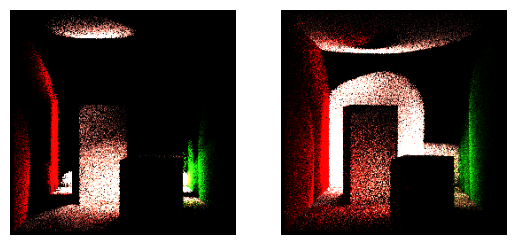

In [ ]:
# Plot some frames of the computed transient image
import matplotlib.pyplot as plt

data_transient_tonemapped[data_transient_tonemapped > 1] = 1

plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(data_transient_tonemapped[:, :, 100])  # frame 100 (video has 300 frames)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(data_transient_tonemapped[:, :, 140])  # frame 140 (video has 300 frames)
plt.show()